In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 30
NUM_CLASSES = 2
DATA_FOLDER = "C:\disser\detCat\dataset\ODIR-5K\Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
%matplotlib inline 

In [2]:
#from tensorflow.applications import ResNet50
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
#from keras.models import Model
#import tensorflow_addons as tfa

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

In [4]:
data_df = pd.read_excel(open("C:\disser\detCat\dataset\ODIR-5K\data.xlsx", 'rb'), sheet_name='Sheet1')

In [5]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [6]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [7]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

cataract                                                                   135
normal fundus                                                               24
cataract，lens dust                                                           8
moderate non proliferative retinopathy                                       6
mild nonproliferative retinopathy                                            5
lens dust，cataract                                                           5
lens dust，normal fundus                                                      4
refractive media opacity                                                     3
cataract，moderate non proliferative retinopathy                              3
normal fundus，lens dust                                                      3
cataract，mild nonproliferative retinopathy                                   2
severe proliferative diabetic retinopathy                                    2
cataract，myelinated nerve fibers，moderate non prolif

In [8]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()

cataract                                                                  127
normal fundus                                                              24
moderate non proliferative retinopathy                                      9
cataract，lens dust                                                          6
lens dust，cataract                                                          5
drusen                                                                      5
mild nonproliferative retinopathy                                           4
refractive media opacity                                                    4
epiretinal membrane                                                         3
moderate non proliferative retinopathy，cataract                             3
cataract，moderate non proliferative retinopathy                             3
macular epiretinal membrane                                                 3
lens dust，normal fundus                                         

In [9]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [10]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [11]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [12]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [13]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [14]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [15]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.99it/s]


In [16]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:30<00:00,  9.98it/s]


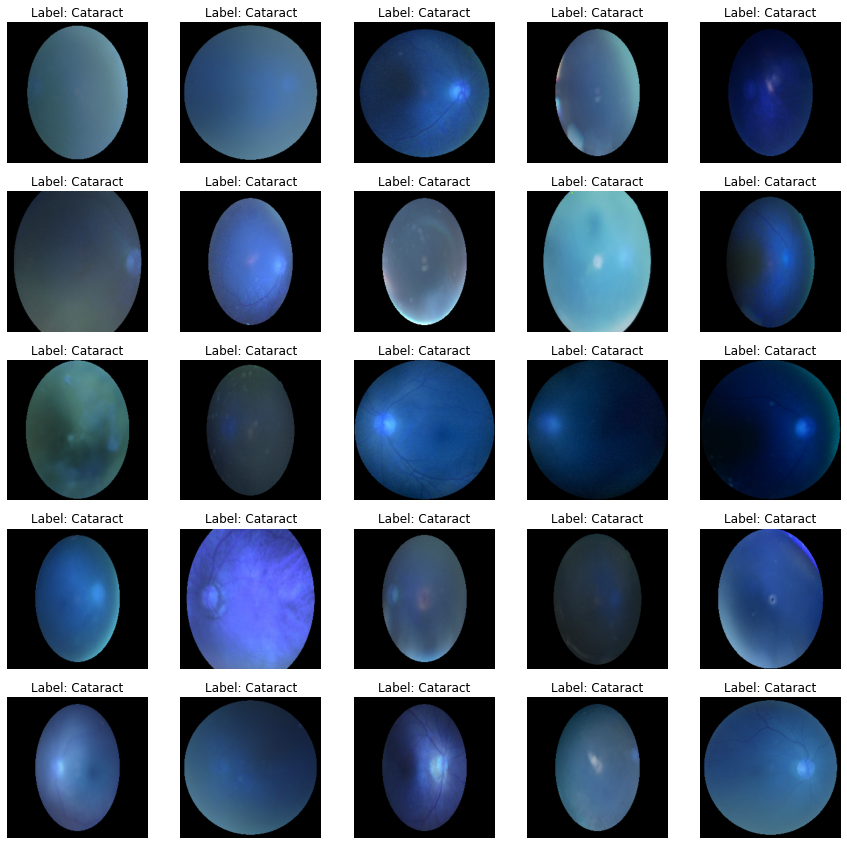

In [17]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)

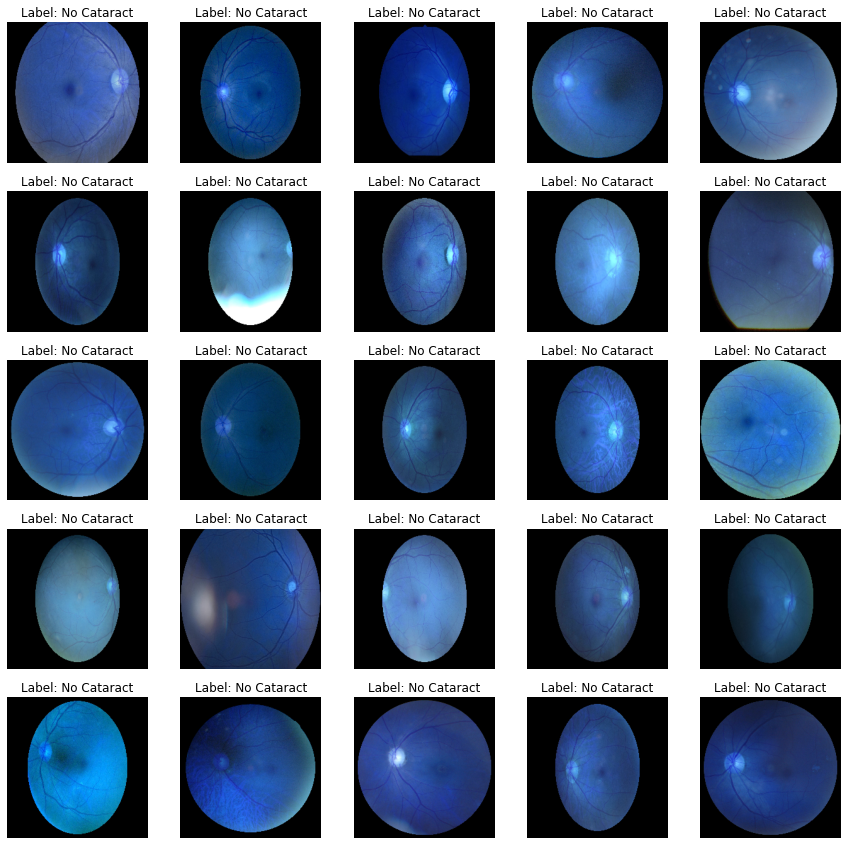

In [18]:
show_images(cat_no_df)

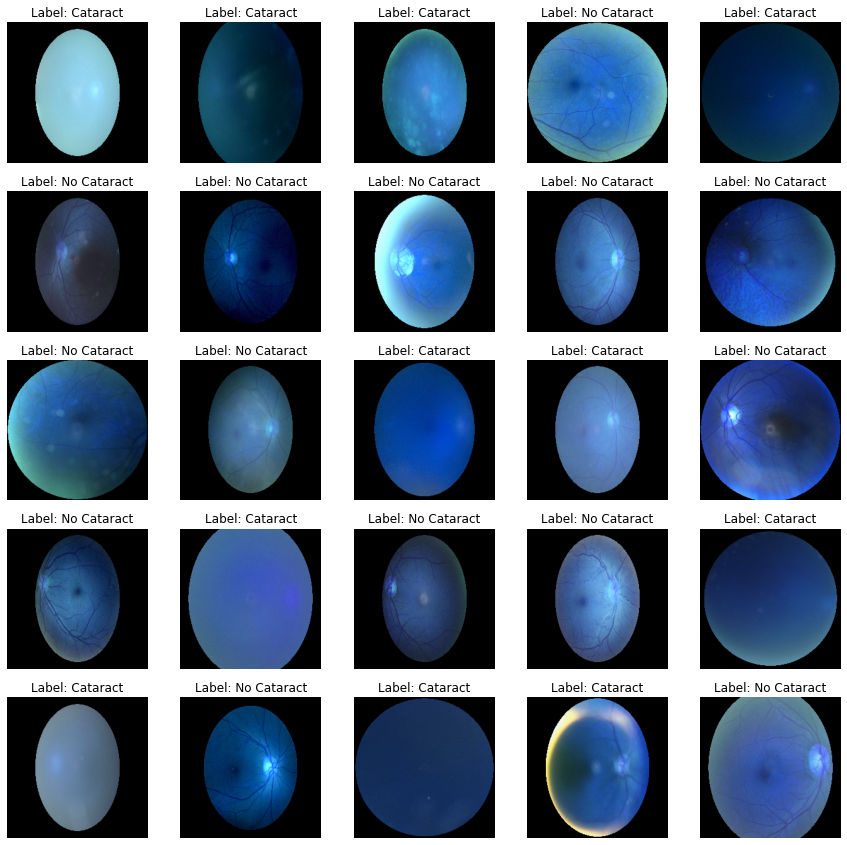

In [19]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [20]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [21]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
# mark loaded layers as not trainable
for layer in resnet.layers:
    layer.trainable = False
output = Flatten()(resnet.layers[-1].output)
resnet = Model(inputs=resnet.inputs, outputs=output)
resnet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [22]:
model = Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 100352)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 75,232,130
Trainable params: 51,644,418
Non-trainable params: 23,587,712
___________________________________

In [23]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [24]:
plot_model(model, to_file='model.png')
(model_to_dot(model).create(prog='dot', format='svg'))

b'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\r\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\r\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\r\n<!-- Generated by graphviz version 2.44.1 (20200629.0800)\r\n -->\r\n<!-- Title: G Pages: 1 -->\r\n<svg width="261pt" height="644pt"\r\n viewBox="0.00 0.00 196.00 483.00" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\r\n<g id="graph0" class="graph" transform="scale(1.33 1.33) rotate(0) translate(4 479)">\r\n<title>G</title>\r\n<polygon fill="white" stroke="transparent" points="-4,4 -4,-479 192,-479 192,4 -4,4"/>\r\n<!-- 1789440018888 -->\r\n<g id="node1" class="node">\r\n<title>1789440018888</title>\r\n<polygon fill="none" stroke="black" points="0,-438.5 0,-474.5 188,-474.5 188,-438.5 0,-438.5"/>\r\n<text text-anchor="middle" x="94" y="-452.8" font-family="Times New Roman,serif" font-size="14.00">functional_1_input: InputLayer</text>\r\n</g>\r\n<!-- 1789438414344 -->\r\n<g id="node2" class=

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [26]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/30
16/16 [==============================] - 13s 796ms/step - loss: 17.2699 - accuracy: 0.5735 - val_loss: 0.5483 - val_accuracy: 0.6341
Epoch 2/30
16/16 [==============================] - 9s 564ms/step - loss: 0.3506 - accuracy: 0.8857 - val_loss: 0.3630 - val_accuracy: 0.8699
Epoch 3/30
16/16 [==============================] - 9s 575ms/step - loss: 0.2559 - accuracy: 0.9224 - val_loss: 0.2707 - val_accuracy: 0.9106
Epoch 4/30
16/16 [==============================] - 9s 576ms/step - loss: 0.2258 - accuracy: 0.9204 - val_loss: 0.2876 - val_accuracy: 0.9106
Epoch 5/30
16/16 [==============================] - 9s 575ms/step - loss: 0.2441 - accuracy: 0.9286 - val_loss: 0.2605 - val_accuracy: 0.9106
Epoch 6/30
16/16 [==============================] - 9s 575ms/step - loss: 0.2394 - accuracy: 0.9347 - val_loss: 0.2622 - val_accuracy: 0.9350
Epoch 7/30
16/16 [==============================] - 9s 575ms/step - loss: 0.2158 - accuracy: 0.9306 - val_loss: 0.2551 - val_accuracy: 0.9268
Epoc

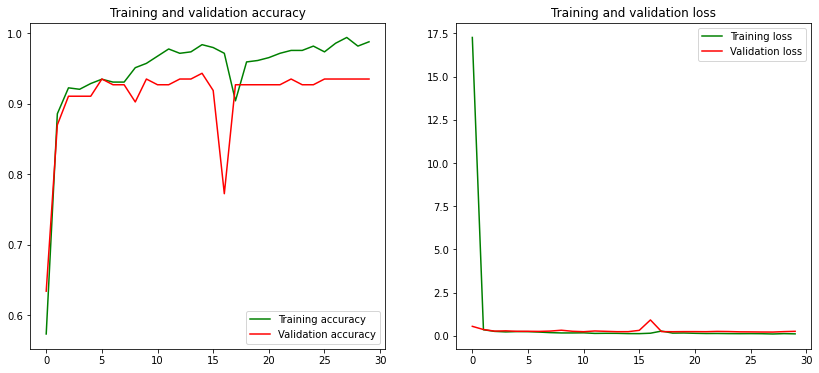

In [27]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [28]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.2595905661582947
Validation accuracy: 0.934959352016449


In [29]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [30]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [31]:
target_names = ["Cataract", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Cataract       0.92      0.95      0.94        63
      Normal       0.95      0.92      0.93        60

    accuracy                           0.93       123
   macro avg       0.94      0.93      0.93       123
weighted avg       0.94      0.93      0.93       123



In [32]:
# evaluate the model
scores = model.evaluate(X_val, y_val, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

accuracy: 93.50%
Saved model to disk


In [33]:
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

# Save the model.
#with open('model.tflite', 'wb') as f:
#  f.write(tflite_model)